<p style="font-size:25px;">**Before using this notebook:**

1. Gather FASTQ files for each round of selection
2. Use APTASUITE to convert raw FASTQ files into tab delimited files containing the Aptamer_Id, Sequence, and number of reads from each round of selection

<p style="font-size:25px;">Load required packages and import data into Counts

Counts is a dictionary with key = sequence, value = {'ID': list, 'Round0':integer, 'Round1':integer, etc}

In [1]:
import numpy as np
import nltk
from Bio import Align
from Bio.Seq import Seq
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import time
import pandas as pd
import warnings


In [2]:
def import_data(Counts, path1, round_list):
    file = open(path1, "r")
    content = file.readlines()
    for i in content[1:]:
        line = i.strip('\n').split('\t')
        ID = line[0]
        sequence = line[1]
        if sequence not in Counts:
            Counts[sequence] = {'ID': [ID]}
            line_num = 2
            for Rn in round_list:
                Counts[sequence]['R' + Rn] = int(line[line_num])
                line_num += 1
        elif sequence in Counts and 'R' + round_list[0] in Counts[sequence]:
            Counts[sequence]['ID'].append(ID)
            line_num = 2
            for Rn in round_list:
                Counts[sequence]['R' + Rn] += int(line[line_num])
                line_num += 1
        elif sequence in Counts and 'R' + round_list[0] not in Counts[sequence]:
            Counts[sequence]['ID'].append(ID)
            line_num = 2
            for Rn in round_list:
                Counts[sequence]['R' + Rn] = int(line[line_num])
                line_num += 1
    file.close()
    return(Counts)


In [3]:
# Import data from each APTASUITE tab delimited file
# Counts = dictionary with key = sequence, value = {'ID': [], 'Round_number':integer}

Counts = {}

path1 = r'D:/093025 NASA backup/In vitro selection of 2 RNAs/090424 - 010325 emulsion selection/092424 sequence data/PairedEndV2/export/pool.txt'
path1_round_list = ['0', '5', '6'] # Each entry in the list is a string
Counts = import_data(Counts, path1, path1_round_list)

path2 = r'D:/093025 NASA backup/iSeqA/2024/20241031_FS10000323_105_BTR99609-1932/Alignment_2/20241104_093040/Fastq/110424analysisV3/export/pool.txt'
path2_round_list = ['8', '8_expected_size', '9', '9_expected_size', '9_small_size'] # Each entry in the list is a string
Counts = import_data(Counts, path2, path2_round_list)

# For any sequences that appear only in the second file, 0 for their counts in the rounds from the first file
all_rounds = path1_round_list + path2_round_list
for s in Counts:
    for r in all_rounds:
        index = 'R' + r
        if index not in Counts[s]:
            Counts[s][index] = 0


<p style="font-size:25px;">Examine the distribution of read lengths for each round

In [4]:
def make_dict1():
    dict1 = {'R0': 0,
             'R5': 0,
             'R6': 0,
             'R8': 0,
             'R8_expected_size': 0,
             'R9': 0,
             'R9_expected_size': 0,
             'R9_small_size': 0}
    return(dict1)

In [5]:
# Count total number of reads per round
reads = make_dict1()
for s in Counts:
    for roundI in reads:
        reads[roundI] += Counts[s][roundI]

print(reads)

{'R0': 1678021, 'R5': 1564154, 'R6': 753632, 'R8': 1075267, 'R8_expected_size': 777742, 'R9': 689343, 'R9_expected_size': 704793, 'R9_small_size': 364529}


In [6]:
# Find number of reads that coresspond to a variant of expected length
greater_than_108 = make_dict1()

exactly_108 = make_dict1()

between_98_and_108 = make_dict1()

less_than_98 = make_dict1()

for s in Counts:
    length = len(s)
    if length > 108:
        for roundI in reads:
            greater_than_108[roundI] += Counts[s][roundI]
    elif length == 108:
        for roundI in reads:
            exactly_108[roundI] += Counts[s][roundI]
    elif length < 108 and length >= 98:
        for roundI in reads:
            between_98_and_108[roundI] += Counts[s][roundI]
    elif length < 98:
        for roundI in reads:
            less_than_98[roundI] += Counts[s][roundI]
        
dict_list = [less_than_98, between_98_and_108, exactly_108, greater_than_108]
for roundI in reads:
    print(roundI)
    percents = [str(np.round(100*q[roundI]/reads[roundI],2)) for q in dict_list]
    print('Less than 98nt = ' + percents[0] + '%, 98-107nt = ' + percents[1] + '%, 108nt = ' + percents[2] + '%, greater than 108nt = ' + percents[3] + '%')
    print()

R0
Less than 98nt = 30.87%, 98-107nt = 7.39%, 108nt = 59.14%, greater than 108nt = 2.6%

R5
Less than 98nt = 25.88%, 98-107nt = 6.01%, 108nt = 64.81%, greater than 108nt = 3.3%

R6
Less than 98nt = 24.63%, 98-107nt = 7.09%, 108nt = 65.23%, greater than 108nt = 3.05%

R8
Less than 98nt = 93.47%, 98-107nt = 0.74%, 108nt = 5.43%, greater than 108nt = 0.37%

R8_expected_size
Less than 98nt = 41.39%, 98-107nt = 6.76%, 108nt = 48.39%, greater than 108nt = 3.46%

R9
Less than 98nt = 88.16%, 98-107nt = 1.61%, 108nt = 9.62%, greater than 108nt = 0.61%

R9_expected_size
Less than 98nt = 64.02%, 98-107nt = 5.03%, 108nt = 28.86%, greater than 108nt = 2.08%

R9_small_size
Less than 98nt = 99.12%, 98-107nt = 0.55%, 108nt = 0.07%, greater than 108nt = 0.26%



Text(1.5, 96, 'Greater than 108nt')

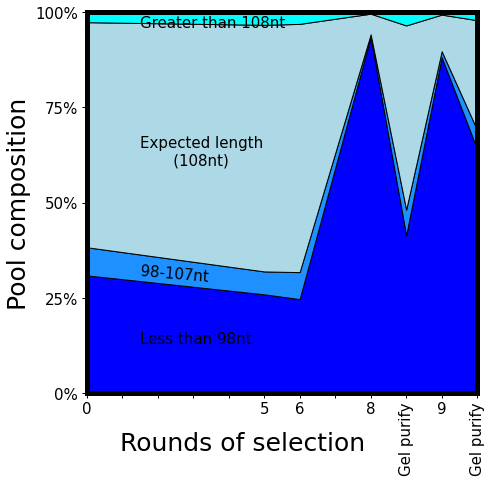

In [7]:
# Plot the number of reads that coresspond to a variant of expected length
def calc_percent(dictI, readsI, roundI):
    return(100*dictI[roundI]/readsI[roundI])

rounds = [0, 5, 6, 8, 9, 10, 11]
rounds_names = ['0', '5', '6', '8', 'Gel purify', '9', 'Gel purify']
keys = ['R0', 'R5', 'R6', 'R8', 'R8_expected_size', 'R9', 'R9_expected_size']
less_than_98_list = [calc_percent(less_than_98, reads, x) for x in keys]
exactly_108_list = [calc_percent(exactly_108, reads, x) for x in keys]
between_98_and_108_list = [calc_percent(between_98_and_108, reads, x) for x in keys]
greater_than_108_list = [calc_percent(greater_than_108, reads, x) for x in keys]
y = np.vstack([less_than_98_list, between_98_and_108_list, exactly_108_list,  greater_than_108_list])

fig, ax = plt.subplots(1, 1, figsize = (7,7))
ax.stackplot(rounds, y, colors = ['blue', 'dodgerblue', 'lightblue', 'cyan'], edgecolor = 'k')

ax.set_xlabel('Rounds of selection', fontsize = 25, labelpad = 0)
ax.xaxis.set_label_coords(.4, -0.1)
ax.set_ylabel('Pool composition', fontsize=25)
ax.tick_params(axis='y',labelsize=15, length = 5, width = 1)
ax.tick_params(axis='x',labelsize=15, length = 5, width = 1)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.set_xticklabels(['0', '', '', '', '', '5', '6', '', '8', 'Gel purify', '9', 'Gel purify'])
ticks = ax.get_xticklabels()
ticks[9].set_rotation(90)
ticks[11].set_rotation(90)
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlim([0,11])
ax.set_ylim([0,100])
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_linewidth(5)

ax.text(1.5, 13, 'Less than 98nt', size = 15, color = 'k')
ax.text(1.5, 29.5, '98-107nt', size = 15, color = 'k', rotation = -5)
ax.text(1.5, 60, 'Expected length\n       (108nt)', size = 15, color = 'k')
ax.text(1.5, 96, 'Greater than 108nt', size = 15, color = 'k')

<p style="font-size:25px;">Examine the distribution of expected length reads


In [8]:
# Create a new dictionary with data from ONLY the expected length reads
Counts_expected = {}
for s in Counts:
    if len(s) == 108:
        Counts_expected[s] = Counts[s]
print(len(Counts))
print(len(Counts_expected)) 


5125957
3104395


In [9]:
# Count total number of reads per round
reads = make_dict1()
for s in Counts_expected:
    for roundI in reads:
        reads[roundI] += Counts_expected[s][roundI]
        
print(reads)

{'R0': 992383, 'R5': 1013668, 'R6': 491628, 'R8': 58363, 'R8_expected_size': 376385, 'R9': 66308, 'R9_expected_size': 203407, 'R9_small_size': 241}


In [10]:
# Count total number of singletons per round
singletons = make_dict1()

for s in Counts_expected:
    for roundI in singletons:
        if Counts_expected[s][roundI] == 1:
            singletons[roundI] += 1
        
print(singletons)

{'R0': 954814, 'R5': 970414, 'R6': 456158, 'R8': 55392, 'R8_expected_size': 360901, 'R9': 59130, 'R9_expected_size': 187360, 'R9_small_size': 227}


In [11]:
# Display the percentage of reads that are singletons in each round
singletons_list = []
for roundI in reads:
    print(roundI)
    val = np.round(100*singletons[roundI]/reads[roundI],2)
    print(str(val) + '% singletons in the pool')
    singletons_list.append(val)
    print()

R0
96.21% singletons in the pool

R5
95.73% singletons in the pool

R6
92.79% singletons in the pool

R8
94.91% singletons in the pool

R8_expected_size
95.89% singletons in the pool

R9
89.17% singletons in the pool

R9_expected_size
92.11% singletons in the pool

R9_small_size
94.19% singletons in the pool



Text(1.5, 96, 'Non singletons')

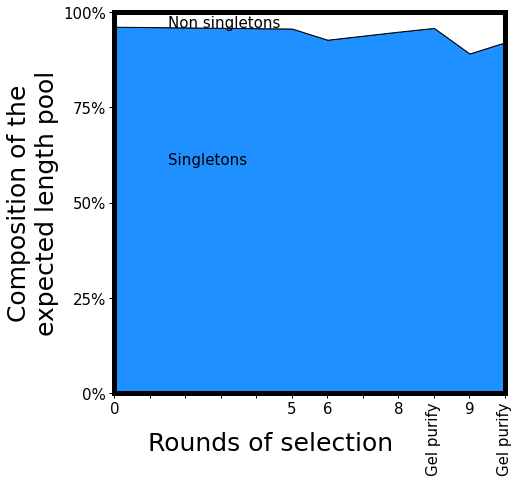

In [12]:
# Plot the number of reads that coresspond to a singleton or nonsingleton
rounds = [0, 5, 6, 8, 9, 10, 11]
rounds_names = ['0', '5', '6', '8', 'Gel purify expected size', '9', 'Gel purify expected size']
#singletons =[96.21, 95.73, 92.79, 94.91, 95.89, 89.17, 92.11]
non_singletons_list = [100 - x for x in singletons_list]
y = np.vstack([singletons_list[:-1], non_singletons_list[:-1]])


fig, ax = plt.subplots(1, 1, figsize = (7,7))
ax.stackplot(rounds, y, colors = ['dodgerblue', 'white'], edgecolor = 'k')

ax.set_xlabel('Rounds of selection', fontsize = 25, labelpad = 0)
ax.xaxis.set_label_coords(.4, -0.1)
ax.set_ylabel('Composition of the\nexpected length pool', fontsize=25)
ax.tick_params(axis='y',labelsize=15, length = 5, width = 1)
ax.tick_params(axis='x',labelsize=15, length = 5, width = 1)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.set_xticklabels(['0', '', '', '', '', '5', '6', '', '8', 'Gel purify', '9', 'Gel purify'])
ticks = ax.get_xticklabels()
ticks[9].set_rotation(90)
ticks[11].set_rotation(90)
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlim([0,11])
ax.set_ylim([0,100])
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_linewidth(5)

ax.text(1.5, 60, 'Singletons', size = 15, color = 'k')
ax.text(1.5, 96, 'Non singletons', size = 15, color = 'k')



<p style="font-size:25px;">Examine the compoisiton of the expected length, non-singleton pool


In [13]:
# For each round, count the number of variants with a certain number of reads (i.e. histogram)
histogram_dict = {'R0': {},
                  'R5': {},
                  'R6': {},
                  'R8': {},
                  'R8_expected_size': {},
                  'R9': {},
                  'R9_expected_size': {},
                  'R9_small_size': {}}

for s in Counts_expected:
    for roundI in histogram_dict:
        if Counts_expected[s][roundI] > 1:
            if Counts_expected[s][roundI] in histogram_dict[roundI]:
                histogram_dict[roundI][Counts_expected[s][roundI]] += 1
            else:
                histogram_dict[roundI][Counts_expected[s][roundI]] = 1

for roundI in histogram_dict:
    print(roundI)
    q = histogram_dict[roundI]
    print(sorted(q.items(), key=lambda item: item[0]))
    print()

R0
[(2, 18183), (3, 393), (4, 6)]

R5
[(2, 20855), (3, 494), (4, 12), (5, 1), (9, 1)]

R6
[(2, 16309), (3, 734), (4, 46), (5, 7), (6, 1), (7, 1), (8, 3), (9, 1), (10, 3), (13, 1), (14, 1), (328, 1)]

R8
[(2, 978), (3, 39), (4, 21), (5, 12), (6, 10), (7, 6), (8, 2), (9, 3), (10, 3), (11, 1), (12, 3), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 2), (20, 1), (22, 1), (24, 1), (28, 1), (30, 1), (31, 1), (54, 2), (61, 1), (69, 1)]

R8_expected_size
[(2, 5673), (3, 206), (4, 60), (5, 38), (6, 23), (7, 11), (8, 13), (9, 7), (10, 9), (11, 11), (12, 4), (13, 2), (14, 6), (15, 2), (16, 5), (17, 6), (18, 3), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (25, 1), (26, 2), (28, 2), (31, 1), (33, 2), (35, 1), (36, 2), (37, 3), (38, 2), (45, 1), (46, 1), (49, 1), (50, 1), (54, 1), (55, 1), (67, 1), (127, 1), (206, 1), (221, 1), (486, 1)]

R9
[(2, 1270), (3, 116), (4, 60), (5, 22), (6, 25), (7, 11), (8, 11), (9, 7), (10, 7), (11, 5), (12, 2), (13, 4), (14, 1), (15, 5), (16, 2), (17, 2), (18, 1), 

Text(7.75, 87, 'Variants with\n>4 reads each')

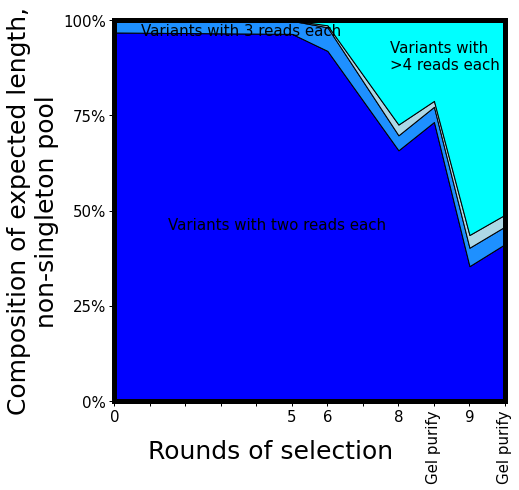

In [14]:
# Plot the number of reads from variants with 2 total reads, or 3 total reads, or 4 total reads. Etc...
rounds = [0, 5, 6, 8, 9, 10, 11]
rounds_names = ['0', '5', '6', '8', 'Gel purify expected size', '9', 'Gel purify expected size']

total_reads = []
for roundI in histogram_dict:
    q = [histogram_dict[roundI][x]*x for x in histogram_dict[roundI]]
    total_reads.append(np.sum(q))
two_reads = [histogram_dict[roundI][2]*2 for roundI in histogram_dict]
three_reads = [histogram_dict[roundI][3]*3 for roundI in histogram_dict]
four_reads = [histogram_dict[roundI][4]*4 if 4 in histogram_dict[roundI] else 0 for roundI in histogram_dict]
greater_than_four_reads = []
for roundI in histogram_dict:
    q = [histogram_dict[roundI][x]*x for x in histogram_dict[roundI] if x > 4]
    greater_than_four_reads.append(np.sum(q))

y = np.vstack([[100*two_reads[x]/total_reads[x] for x in range(len(rounds))],
               [100*three_reads[x]/total_reads[x] for x in range(len(rounds))], 
               [100*four_reads[x]/total_reads[x] for x in range(len(rounds))],
               [100*greater_than_four_reads[x]/total_reads[x] for x in range(len(rounds))]
              ])


fig, ax = plt.subplots(1, 1, figsize = (7,7))
ax.stackplot(rounds, y, colors = ['blue', 'dodgerblue', 'lightblue', 'cyan'], edgecolor = 'k')

ax.set_xlabel('Rounds of selection', fontsize = 25, labelpad = 0)
ax.xaxis.set_label_coords(.4, -0.1)
ax.set_ylabel('Composition of expected length,\nnon-singleton pool', fontsize=25)
ax.tick_params(axis='y',labelsize=15, length = 5, width = 1)
ax.tick_params(axis='x',labelsize=15, length = 5, width = 1)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.set_xticklabels(['0', '', '', '', '', '5', '6', '', '8', 'Gel purify', '9', 'Gel purify'])
ticks = ax.get_xticklabels()
ticks[9].set_rotation(90)
ticks[11].set_rotation(90)
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlim([0,11])
ax.set_ylim([0,100])
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_linewidth(5)

ax.text(1.5, 45, 'Variants with two reads each', size = 15, color = 'k')
ax.text(.75, 96, 'Variants with 3 reads each', size = 15, color = 'k')
ax.text(7.75, 87, 'Variants with\n>4 reads each', size = 15, color = 'k')


<p style="font-size:25px;"> Take all the expected length, non-singleton sequences across all rounds.
<p style="font-size:25px;"> Find number of reads that coresspond to a variant that encodes 0, 1, or 2 RNAs
<p style="font-size:12px;"> First, set parameter values:
<p style="font-size:12px;"> read_threshold = each variant must have more reads in the given round than the read threshold to be considered in this calculation
<p style="font-size:12px;"> promoter_tolerance = maximum edit distance to classify a substring as containing the T7 promoter


In [15]:
read_threshold = 1
promoter_tolerance = 2

In [16]:
def is_promoter_present(DNA1, tolerance):
    # Determine if T7 promoter sequence is present (and thus if this strand encodes an RNA). 
    # First, check if exact promoter sequence is present.
    # If not, check for a substring that has an edit distance with the promoter sequence less than tolerance
    T7_promoter = Seq('TAATACGACTCACTATAGG')
    if DNA1.find(T7_promoter) != -1:
        return(1)
    for i in range(len(DNA1) - len(T7_promoter)):
        substring = DNA1[i:i + len(T7_promoter)]
        edit_dist = nltk.edit_distance(substring, T7_promoter)
        if edit_dist <= tolerance:
            return(1)
    return(0)

def find_all_promoters(DNA1, tolerance):
    promoter_count = is_promoter_present(DNA1, tolerance)
    DNA_rev_comp = DNA1.reverse_complement()
    promoter_count += is_promoter_present(DNA_rev_comp, tolerance)
    return(promoter_count)

In [17]:
# Find number of reads that coresspond to a variant that encodes 0, 1, or 2 RNAs
number_of_RNAs = {'R0': {'zero':0, 'one':0, 'two':0},
                  'R5': {'zero':0, 'one':0, 'two':0},
                  'R6': {'zero':0, 'one':0, 'two':0},
                  'R8': {'zero':0, 'one':0, 'two':0},
                  'R8_expected_size': {'zero':0, 'one':0, 'two':0},
                  'R9': {'zero':0, 'one':0, 'two':0},
                  'R9_expected_size': {'zero':0, 'one':0, 'two':0},
                  'R9_small_size': {'zero':0, 'one':0, 'two':0}}


variants = {'R0': [],
              'R5': [],
              'R6': [],
              'R8': [],
              'R8_expected_size': [],
              'R9': [],
              'R9_expected_size': [],
              'R9_small_size': []}
for s in Counts_expected:
    for roundI in variants:
        if Counts_expected[s][roundI] > read_threshold:
            variants[roundI].append(s)
total_number_of_variants = np.sum([len(variants[x]) for x in variants])


checks = [time.time()]
tracker = 0
for roundI in number_of_RNAs:
    for s in variants[roundI]:
        tracker += 1
        promoter_count = find_all_promoters(Seq(s), promoter_tolerance)
        if promoter_count == 0:
            number_of_RNAs[roundI]['zero'] += Counts_expected[s][roundI]
        elif promoter_count == 1:
            number_of_RNAs[roundI]['one'] += Counts_expected[s][roundI]
        elif promoter_count == 2:
            number_of_RNAs[roundI]['two'] += Counts_expected[s][roundI]
        if time.time() - checks[-1] > 60:
            print(str(np.round(100*tracker/total_number_of_variants,2)) + '% of all sequences have been analyzed')
            checks.append(time.time())
        
for roundI in number_of_RNAs:
    print(roundI)
    total_included = number_of_RNAs[roundI]['zero'] + number_of_RNAs[roundI]['one'] + number_of_RNAs[roundI]['two']
    zero = str(np.round(100*number_of_RNAs[roundI]['zero']/total_included,2))
    one = str(np.round(100*number_of_RNAs[roundI]['one']/total_included,2))
    two = str(np.round(100*number_of_RNAs[roundI]['two']/total_included,2))
    print('Zero RNAs = ' + zero + '%, one RNA = ' + one + '%, two RNAs = ' + two + '%')
    print()

6.41% of all sequences have been analyzed
12.64% of all sequences have been analyzed
19.2% of all sequences have been analyzed
26.09% of all sequences have been analyzed
40.02% of all sequences have been analyzed
56.02% of all sequences have been analyzed
67.68% of all sequences have been analyzed
80.96% of all sequences have been analyzed
94.41% of all sequences have been analyzed
R0
Zero RNAs = 0.0%, one RNA = 32.28%, two RNAs = 67.72%

R5
Zero RNAs = 0.0%, one RNA = 7.71%, two RNAs = 92.29%

R6
Zero RNAs = 0.0%, one RNA = 12.05%, two RNAs = 87.95%

R8
Zero RNAs = 0.0%, one RNA = 17.0%, two RNAs = 83.0%

R8_expected_size
Zero RNAs = 0.0%, one RNA = 4.6%, two RNAs = 95.4%

R9
Zero RNAs = 0.0%, one RNA = 39.61%, two RNAs = 60.39%

R9_expected_size
Zero RNAs = 0.0%, one RNA = 19.36%, two RNAs = 80.64%

R9_small_size
Zero RNAs = 0.0%, one RNA = 71.43%, two RNAs = 28.57%



In [18]:
zero_RNAs = []
one_RNA = []
two_RNAs = []

for roundI in number_of_RNAs:
    total_included = number_of_RNAs[roundI]['zero'] + number_of_RNAs[roundI]['one'] + number_of_RNAs[roundI]['two']
    zero_RNAs.append(100*number_of_RNAs[roundI]['zero']/total_included)
    one_RNA.append(100*number_of_RNAs[roundI]['one']/total_included)
    two_RNAs.append(100*number_of_RNAs[roundI]['two']/total_included)

Text(4, 65, 'Encode 2 RNAs')

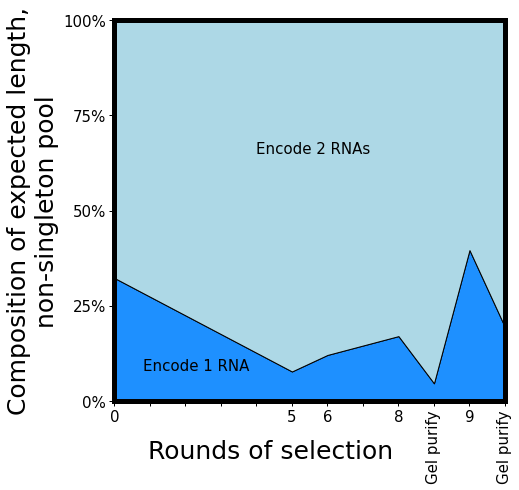

In [19]:
# Plot the percentage of variants in each round that encode 0, 1, or 2 RNAs
rounds = [0, 5, 6, 8, 9, 10, 11]
rounds_names = ['0', '5', '6', '8', 'Gel purify expected size', '9', 'Gel purify expected size']

y = np.vstack([zero_RNAs[:-1], one_RNA[:-1], two_RNAs[:-1]])


fig, ax = plt.subplots(1, 1, figsize = (7,7))
ax.stackplot(rounds, y, colors = ['cyan', 'dodgerblue', 'lightblue'], edgecolor = 'k')

ax.set_xlabel('Rounds of selection', fontsize = 25, labelpad = 0)
ax.xaxis.set_label_coords(.4, -0.1)
ax.set_ylabel('Composition of expected length,\nnon-singleton pool', fontsize=25)
ax.tick_params(axis='y',labelsize=15, length = 5, width = 1)
ax.tick_params(axis='x',labelsize=15, length = 5, width = 1)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.set_xticklabels(['0', '', '', '', '', '5', '6', '', '8', 'Gel purify', '9', 'Gel purify'])
ticks = ax.get_xticklabels()
ticks[9].set_rotation(90)
ticks[11].set_rotation(90)
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlim([0,11])
ax.set_ylim([0,100])
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_linewidth(5)

ax.text(.8, 8, 'Encode 1 RNA', size = 15, color = 'k')
ax.text(4, 65, 'Encode 2 RNAs', size = 15, color = 'k')
